In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

In [2]:
data = pd.read_csv('winequality-red.csv')

# EDA

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [4]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [5]:
data.loc[:, 'quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

# Feature Enginnering

In [6]:
# 0 -  bad quality; 1 - good quality
data['rating'] = pd.cut(data['quality'], bins = [0, 5, 10], labels = [0, 1]).astype('int')

In [7]:
data['rating'].value_counts()

1    855
0    744
Name: rating, dtype: int64

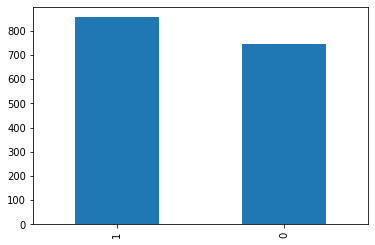

In [8]:
data['rating'].value_counts().plot(kind='bar')
plt.show()

# Data Processing

In [9]:
X = data.drop(['quality', 'rating'], axis='columns')
y = data['rating']

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# Spliting imbalanced Data into Train/Test Set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify = y)

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=1)
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 1,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [13]:
params = {
    'C': [1, 5, 10, 20], 
    'penalty': ['l1', 'l2']
}

In [14]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kfolds = StratifiedKFold(5)
clf = GridSearchCV(lr, param_grid=params, cv = kfolds.split(X_train,y_train), scoring='f1')
clf.fit(X_train, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x00000187D1A083C0>,
             estimator=LogisticRegression(random_state=1),
             param_grid={'C': [1, 5, 10, 20], 'penalty': ['l1', 'l2']},
             scoring='f1')

In [15]:
best_lr = clf.best_estimator_

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

pred = best_lr.predict(X_test)
print('classification report')
print(classification_report(y_test, pred))
print('=====================')
print('confusion matrix')
print(confusion_matrix(y_test, pred))

classification report
              precision    recall  f1-score   support

           0       0.70      0.73      0.72       186
           1       0.76      0.73      0.75       214

    accuracy                           0.73       400
   macro avg       0.73      0.73      0.73       400
weighted avg       0.73      0.73      0.73       400

confusion matrix
[[136  50]
 [ 57 157]]


In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(best_lr, X_train, y_train, cv = 5).mean()

0.7456380753138075

# SMOTE for imbalanced dataset

In [18]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=1)
X_res, y_res = sm.fit_resample(X_scaled, y)

In [19]:
y_res.value_counts()

0    855
1    855
Name: rating, dtype: int64

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify = y)
kfolds = StratifiedKFold(5)
clf = GridSearchCV(lr, param_grid=params, cv = kfolds.split(X_train,y_train), scoring='f1')
clf.fit(X_train, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x00000187D20BAF90>,
             estimator=LogisticRegression(random_state=1),
             param_grid={'C': [1, 5, 10, 20], 'penalty': ['l1', 'l2']},
             scoring='f1')

In [21]:
lr_SMOTE = clf.best_estimator_
pred = lr_SMOTE.predict(X_test)
print('classification report')
print(classification_report(y_test, pred))
print('=====================')
print('confusion matrix')
print(confusion_matrix(y_test, pred))

classification report
              precision    recall  f1-score   support

           0       0.68      0.78      0.73       186
           1       0.78      0.69      0.73       214

    accuracy                           0.73       400
   macro avg       0.73      0.73      0.73       400
weighted avg       0.74      0.73      0.73       400

confusion matrix
[[145  41]
 [ 67 147]]


In [22]:
cross_val_score(lr_SMOTE, X_train, y_train, cv=5).mean()

0.7347489539748955